In [1]:
#구글드라이브와 colab 파일 연결

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
import matplotlib.pyplot as pylab
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float
import matplotlib.image as mpimg

import matplotlib.pylab as pylab
from skimage import img_as_float

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline #얼굴 이미지 처리를 위해 필요한 모듈들 


def LoadIrisimg(): #홍채 이미지를 불러오는 함수.
#121번 사진이 없어서 122번부터 190번까지는 ID를 하나씩 땡겨서 121~189번으로 생각하기로 했다.
#001_01~190_10를 iris[0]~iris[1889] 로 불러옴.
#따라서 iris[index] 에서 사람 번호인 personID = (index // 10 + 1),
#사진 번호를 photoID라 하면 photoID = (index % 10 + 1) 와 같다.

  #1~9번 사람은 그 사람의 ID인 사진 파일 이름이 001~009,
  #10~99번은 011~099, 100~190번은 100~190 으로 되어있어
  #문자열을 맞추기 위해 ID가 한자릿수, 십자릿수, 백자릿수를 최대로 하는 것에 따라
  #for문을 따로 이용했다.


  iris = [] #iris 배열 선언하여 얼굴 이미지들을 순서대로 삽입

  for i in range(1,10): #일의 자릿수 ID
    for j in range(1,11): 
      if(j!=10):
        img = img_as_float(imread('/gdrive/My Drive/ColabNote/iris/iris_00'+str(i)+'_0'+str(j)+'.bmp'))
        iris.append(img)
      else: #10번 data는 앞에 0이 붙지 않아 따로 처리
        img = img_as_float(imread('/gdrive/My Drive/ColabNote/iris/iris_00'+str(i)+'_'+str(j)+'.bmp'))
        iris.append(img)
    
  for i in range(10,100): #십의 자릿수 ID
    for j in range(1,11):
      if(j!=10):
        img = img_as_float(imread('/gdrive/My Drive/ColabNote/iris/iris_0'+str(i)+'_0'+str(j)+'.bmp'))
        iris.append(img)
      else: #10번 data는 앞에 0이 붙지 않아 따로 처리
        img = img_as_float(imread('/gdrive/My Drive/ColabNote/iris/iris_0'+str(i)+'_'+str(j)+'.bmp'))
        iris.append(img)

  for i in range(100,191): #백의 자릿수 ID
    if(i!=121):
      for j in range(1,11): 
        if(j!=10):
          img = img_as_float(imread('/gdrive/My Drive/ColabNote/iris/iris_'+str(i)+'_0'+str(j)+'.bmp'))
          iris.append(img)
        else: #10번 data는 앞에 0이 붙지 않아 따로 처리
          img = img_as_float(imread('/gdrive/My Drive/ColabNote/iris/iris_'+str(i)+'_'+str(j)+'.bmp'))
          iris.append(img)
  

  iris = np.array(iris) #iris에 모두 넣었으므로, 적절한 연산을 위해 numpy 배열로 바꾼다.
  
  return iris

(1890, 32, 226)


<Figure size 432x288 with 0 Axes>

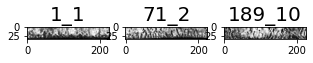

In [3]:
iris = LoadIrisimg() #이미지 불러오기.

pylab.gray()
#이미지가 잘 저장되었는지 확인
pylab.figure(figsize=(5,5))
pylab.subplot(1,3,1), pylab.axis('on')
pylab.title('1_1', size=20)
pylab.imshow(iris[0])

pylab.subplot(1,3,2), pylab.axis('on')
pylab.title('71_2', size=20)
pylab.imshow(iris[10*(71-1) + (2-1)])

pylab.subplot(1,3,3), pylab.axis('on')
pylab.title('189_10', size=20)
pylab.imshow(iris[1889])

print(iris.shape)

pylab.show()

In [4]:
#training set과 test set 나누기
iris_train = [] #학습데이터
iris_test = [] #테스트데이터

#한 사람당 홍채 데이터가 10개씩 있었으므로,
for i in range(0,1890):
  #photoID = (index % 10 - 1) 이므로, i%10 == 0 , 1 이면, 각 사람의 1, 2번 홍채
  if( (i%10 == 0) or (i%10 ==1)): #n번째 사람의 1~2번 data는 test data로
    iris_test.append(iris[i])
  else: #3~10번 data는 training data로 사용
    iris_train.append(iris[i])


iris_train = np.array(iris_train)
iris_test = np.array(iris_test)
print(len(iris_train), len(iris_test), len(iris_train)+len(iris_test))

1512 378 1890


In [0]:
print(iris_test.shape, iris_train.shape)

(378, 32, 226) (1512, 32, 226)


(1512, 400)


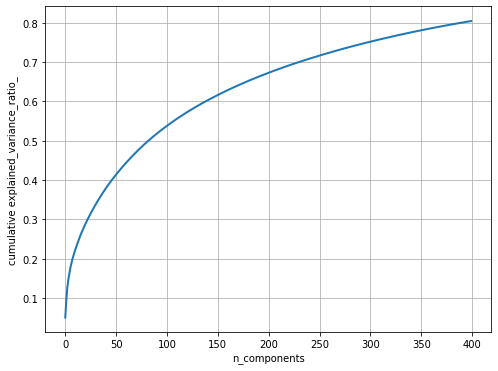

In [5]:
#주성분의 variation을 살펴보기

n_comp = 400  #파이썬에서 사용 가능한 최대 차원인 400차원으로 돌려보기.
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_comp))])

#처리하기 편한 형태로 reshape
iris_train = np.reshape(iris_train, (1512, 7232))
iris_test = np.reshape(iris_test, (378, 7232))

iris_proj = pipeline.fit_transform(iris_train) #iris_train(학습데이터)에 대해 pca 정보 적용 400차원으로
print(iris_proj.shape)


#400차원을 모두 사용해도 0.9가 안된다는 것을 알 수 있었다.
pylab.figure(figsize=(8,6))
variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
pylab.plot(np.cumsum(variance_ratio), linewidth=2)
pylab.grid(),pylab.axis('tight'),pylab.xlabel('n_components')
pylab.ylabel('cumulative explained_variance_ratio_')
pylab.show()  

In [6]:
#누적값이 0.9가 되는 주성분 개수는 661개로 파이썬에서 할 수 있는 임계치를 넘어
#누적값이 0.8가 되는 주성분 개수를 찾기 위해 사용 
pca = PCA(0.8)
pca.fit(iris_train)
print(pca.n_components_) 

380


(1512, 380)


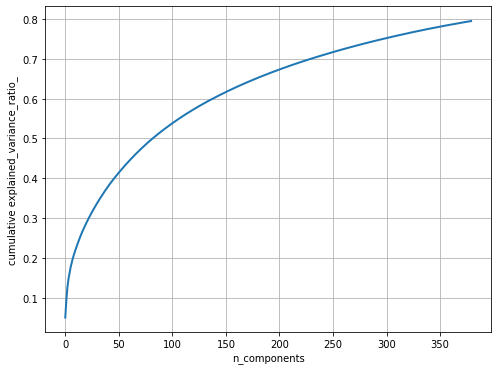

In [7]:
n_comp = 380 #설명력 0.8
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_comp))])
iris_proj = pipeline.fit_transform(iris_train) #학습 데이터에 대해 51차원으로 pca 정보 적용 
print(iris_proj.shape)


mean_iris = np.reshape(pipeline.named_steps['scaling'].mean_, (32,226))
sd_iris = np.reshape(np.sqrt(pipeline.named_steps['scaling'].var_), (32,226)) 


pylab.figure(figsize=(8,6))
variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_ #고유값
pylab.plot(np.cumsum(variance_ratio), linewidth=2)
pylab.grid(),pylab.axis('tight'),pylab.xlabel('n_components')
pylab.ylabel('cumulative explained_variance_ratio_')
pylab.show()

In [0]:
#3. identification / verification 에서 공통으로 사용할 거리 계산

#identification
#(1) 각 홍채에 대한 특징벡터를 계산
#(2) 특징벡터 간의 거리를 계산
#(3) 거리가 가장 작은 8, 4, 1개의 홍채는 동일 ID로 취급하여
#(4) mr 계산


#특징벡터 계산
iris_proj = pca.transform(iris_train)
iris_test_proj = pca.transform(iris_test) #test data는 fit 단계를 거치지 않고 투영시킴

'''
iris_test_proj = []
reshape_mean = np.reshape(mean_iris, (32*226,)) 
reshape_sd = np.reshape(sd_iris, (32*226,))

for i in range(378): #test_data 378개와
  for j in range(380): #주성분 380개에 대해 특징벡터 연산 수행
    vector = np.dot(np.transpose(pca.components_[j]),(iris_test[i]-reshape_mean)) #이렇게 하면 identification1과 같은 결과
    iris_test_proj.append(vector)

iris_test_proj = np.array(iris_test_proj)
iris_test_proj = np.reshape(iris_test_proj, (378,380))
'''

#특징벡터간의 거리 계산
distance = np.zeros((378,378*4))

for i in range(0,378): #test
  for j in range(0, 378*4): #train
    distance[i][j] = np.sqrt(np.sum((iris_test_proj[i]-iris_proj[j])**2)) #거리는 유클리드 거리를 이용한다.
    #distance[i][j] 에는, (i+1)번째 사람의 (i%2 + 1)번째 홍채와 (j//8 + 1))번째 사람의 (j%4 + 3) 번째 홍채 사이의 거리가 담겨있음.

distance = np.array(distance)


#제대로 담겼는지 확인
#print(np.sqrt(np.sum((faces_test_proj[0]-faces_proj[0])**2)))
#print(distance[0][0])

#print(distance)
#print(len(distance[0]))

In [0]:
#다음에 나올 min의 초기값과 verification의 dth를 결정하기 위해 
#length 값을 변경하며 값이 있는지 알아봄.

length = 100  
for i in range(378):
  for j in range(378*4):
    if(distance[i][j] > length): #거리
      print(distance[i][j])
      break

#거리값은 0~39 사이에 분포하고 있었다.

In [9]:
#3-1. identification
#거리가 가장 작은 홍채 8, 4, 1개는 동일 ID로 취급한다.

min_index = 0
min_index_array = np.zeros((378,8))
dist_compare = np.zeros(378)

for i in range(378): #378개의 test data에 대해 378*4개의 training data와 비교
  dist_compare = distance[i].copy()
  for k in range(8): #거리가 가장 작은 홍채 8개를 찾기 위해 8번 반복
    min = 500           #거리가 가장 작은 홍채 8개를 찾기 위해 min 값을 distance 값에 존재하지 않는 500으로 설정
    for j in range(378*4): #378*4개의 training data와 비교
      if(min > dist_compare[j]): 
        min = dist_compare[j]
        min_index = j

    min_index_array[i][k] = (min_index // 8) # 가장 작은 거리값의 id (0~188) 를 저장
    #배열 index 특성상 1~189인 ID가 0~188이 되었다.
    dist_compare[min_index] = 500 
    #가장 작은 거리값을 4개 찾아야 하므로, 
    #현재 가장 작은 값을 가지는 곳이 또 나오면 안됨. 그 곳의 값을 500으로 변경.

np.set_printoptions(suppress=True)
#print(min_index_array)


#matching_rate 계산
mr = np.zeros(378)
mr4 = np.zeros(378)

#거리가 가장 작은 8개의 홍채를 같은 ID로 인식 했을 때
for i in range(378):
  mr8count = 0
  for j in range(8):
    if(i//2 == min_index_array[i][j]): #ID가 같으면 count를 증가시킴. #여기서 test data가 사람당 2개씩이라 i//2를 해야함.
      mr8count += 1
  mr[i] = 100 * mr8count / 8    #test data 각각에 대해 8개 중 몇 개의 ID가 일치하는지 퍼센트로 나타냄.

mr8_result = 0
for i in range(378):
  mr8_result += mr[i] / 378    #위에서 378개에 test data에 대해 각각 구한 일치비율의 평균을 낸다.


#거리가 가장 작은 4개의 홍채를 같은 ID로 인식 했을 때
for i in range(378):
  mr4count = 0
  for j in range(4):
    if(i//2 == min_index_array[i][j]): #ID가 같으면 count를 증가시킴. #여기서 test data가 사람당 2개씩이라 i//2를 해야함.
      mr4count += 1
  mr4[i] = 100 * mr4count / 4    #test data 각각에 대해 4개 중 몇개의 ID가 일치하는지 퍼센트로 나타냄.

mr4_result = 0
for i in range(378):
  mr4_result += mr4[i] / 378    #위에서 378개에 test data에 대해 각각 구한 일치비율의 평균을 낸다.


#거리가 가장 작은 1개의 홍채를 같은 ID로 인식 했을 때
mr1count = 0
for i in range(378):
  if(i//2 == min_index_array[i][0]): #ID가 같으면 count를 증가시킴.
    mr1count += 1

mr1result = 100*mr1count / 378 #전체 test data에 대해 같은 사람의 ID로 식별된 것의 비율을 퍼센트로 나타냄

print(mr1result, mr4_result, mr8_result)

98.41269841269842 95.76719576719616 85.05291005291016


In [11]:
#확인용
#print(min_index_array)
#print(mr)

#identification 시각화 (상위 8개에 대해)
for i in range(350):
  for j in range(8):
    print(int(min_index_array[i][j]), end = ' ')
  print(mr[i])

0 0 0 0 0 0 0 145 87.5
0 0 0 0 0 0 0 145 87.5
1 1 1 1 1 1 1 1 100.0
1 1 1 1 1 1 1 1 100.0
2 2 20 54 38 34 54 60 25.0
2 2 38 49 49 54 41 47 25.0
3 3 3 3 3 119 3 119 75.0
3 3 3 3 3 119 119 69 62.5
4 4 4 4 4 4 33 37 75.0
4 4 4 4 33 33 33 4 62.5
5 5 5 5 5 5 5 78 87.5
5 5 5 5 5 5 5 61 87.5
6 6 6 6 173 19 148 19 50.0
6 6 6 6 6 79 173 148 62.5
7 7 7 7 7 7 7 139 87.5
7 7 7 7 7 7 119 119 75.0
8 8 8 8 11 87 32 119 50.0
8 8 182 182 8 11 8 182 50.0
9 9 9 9 9 9 9 82 87.5
9 9 9 9 9 9 9 74 87.5
151 10 151 151 69 69 151 69 12.5
10 10 10 10 10 10 33 154 75.0
11 11 11 11 11 11 11 20 87.5
11 11 11 11 11 11 11 88 87.5
12 12 12 12 12 12 25 25 75.0
12 12 12 12 25 182 25 173 50.0
13 13 13 7 7 13 13 78 62.5
13 13 13 13 13 13 7 7 75.0
14 14 14 14 14 14 14 47 87.5
14 14 14 14 14 14 14 25 87.5
15 15 15 7 61 15 117 33 50.0
159 47 159 116 116 7 116 20 0.0
16 16 16 16 47 47 38 145 50.0
16 16 16 16 47 38 47 49 50.0
17 17 17 17 17 65 25 156 62.5
17 17 17 17 17 17 17 65 87.5
18 18 18 18 18 7 23 7 62.5
18 18 18 18 18 1

In [20]:
#3-2. verification
#dth를 적당히 10개 정해야 하는데 위에서 살펴본 결과
#distance 배열에 저장된 거리 값은 0~39 사이에 분포했으므로,
#0~40을 4부터 40까지 4 간격으로 10개로 나누기로 했다.
def Verification(dth):

  frr = np.zeros(378)
  far = np.zeros(378)


  #dth 보다 거리가 작으면 매칭된 것으로 판단.
  for i in range(2*189):
    frr_count = 0
    far_count = 0
    for j in range(8*189):
      if(i//2 == j//8):  #ID가 같은 경우엔 frr 계산
        if(distance[i][j] < dth):
          frr_count += 1
      else:
        if(distance[i][j] < dth): #ID가 다른 경우엔 far 계산
          far_count += 1

    frr[i] = 100 * (8-frr_count) / 8 # i번 사람에 대한 frr 값 (i 번 사람의 test 얼굴 2개, i번 사람의 training 얼굴 8개) 
    far[i] = 100 * far_count / (8*188) # i번 사람에 대한 far 값 (i번 사람을 제외한 training 얼굴 8*188개)


  frr_result = 0
  far_result = 0
  for i in range(378): 
    frr_result += frr[i]
    far_result += far[i]

  frr_result = frr_result / 378
  far_result = far_result / 378
  #위에서 구한 378개의 test_data에 대해 각각 계산했던 frr, far 값을 평균내서 
  #전체 frr,far값을 구한다.

  print(frr_result, far_result)
  return frr_result, far_result



dth = 4
dths = np.zeros(10)
frr = np.zeros(10)
far = np.zeros(10)

#dth를 4 간격으로 10번 검증 함수 돌림
for i in range(10):
  dths[i] = dth
  frr[i], far[i] = Verification(dth) 
  dth += 4
#이 때, dth값과 verification 함수의 반환 값인 10개의 frr, far값을 배열에 저장하여 그래프를 그리는데 사용한다.

99.93386243386243 0.0
91.005291005291 0.0
63.59126984126984 0.0
35.44973544973545 0.017941573792637618
13.558201058201059 2.441461218056962
3.3399470899470898 30.15398091860859
0.3637566137566138 83.72153973882696
0.0 99.17187324102215
0.0 99.97625379939213
0.0 100.0


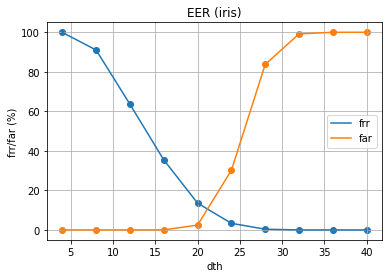

In [21]:
#3-3. EER 그래프 그리기 
import pandas as pd
import matplotlib.pyplot as plt


#그래프 선 그리기
plt.plot(dths, frr, label = 'frr')
plt.plot(dths, far, label = 'far')


#그래프 점 그리기
plt.scatter(dths, frr)
plt.scatter(dths, far)

#그래프 옵션
plt.grid()
plt.legend()
plt.xlabel('dth')
plt.ylabel('frr/far (%)')
plt.title('EER (iris)')

plt.show()

In [22]:
#거리가 가장 작은 8개 이용.
def Verification2():

  frr = np.zeros(378)
  far = np.zeros(378)


  #dth 보다 거리가 작으면 매칭된 것으로 판단.
  for i in range(2*189):
    frr_count = 0
    far_count = 0
    for j in range(8):
      if(i//2 == min_index_array[i][j]):  #ID가 같은 경우엔 frr 계산
        frr_count += 1
      else: #ID가 다른 경우엔 far 계산
        far_count += 1

    frr[i] = 100 * (8-frr_count) / 8 # i번 사람에 대한 frr 값 (i 번 사람의 test 얼굴 1개, i번 사람의 training 얼굴 8개) 
    far[i] = 100 * far_count / (8*188) # i번 사람에 대한 far 값 (i번 사람을 제외한 training 얼굴 8*188개)


  frr_result = 0
  far_result = 0
  for i in range(378): 
    frr_result += frr[i]
    far_result += far[i]

  frr_result = frr_result / 378
  far_result = far_result / 378
  #위에서 구한 378개의 test_data에 대해 각각 계산했던 frr, far 값을 평균내서 
  #전체 frr,far값을 구한다.

  print(frr_result, far_result)
  return frr_result, far_result


frr, far = Verification2()

14.947089947089948 0.07950579759090416
